# <center> COVID-19 Spread Simulation </center>

## <center> https://github.com/DmitrySerg/COVID-19 </center>

Let's play a little Plague Inc. 
![](../pictures/spread.png)

**Author: Dmitry Sergeev**

**Senior Data Scientist @ ŌURA Health, Head of Data Science Programme @ Otus**

**Telegram: @dmitryserg**


Data description: This project uses a collection of datasets, describing the current outbreak of coronavirus disease (COVID-19). The data includes: world airport locations, connections and estimated number of flights per month between them (taken from https://www.flightconnections.com/), estimated population on country and city level (http://worldpopulationreview.com/world-cities/), as well as the current outbreak monitoring data, provided by the Johns Hopkins University Center for Systems Science and Engineering (JHU CCSE) on the number of confirmed, recovered, and death cases (https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data).

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from tqdm import tqdm_notebook
from multiprocessing import Pool
from collections import ChainMap
from joblib import Parallel, delayed
from scipy.special import logit, expit

import warnings
warnings.filterwarnings("ignore")

from sir_model import SIR

In [3]:
airport_df = pd.read_csv("../data/airport_df_preprocessed.csv", index_col=0)
airport_df.head()

,Name,City,Country,IATA,Lat,Long,city_population,country_population,country_density,source_airport,destination_flights,flights_coefficient
0,Goroka Airport,Goroka,Papua New Guinea,GKA,-6.081690,145.391998,43741.0,8776109.0,18.9614,GKA,306.0,142.943199
1,Madang Airport,Madang,Papua New Guinea,MAG,-5.207080,145.789001,24444.0,8776109.0,18.9614,MAG,171.0,142.943199
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,-5.826790,144.296005,74903.0,8776109.0,18.9614,HGU,524.0,142.943199
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,-6.569803,146.725977,101061.0,8776109.0,18.9614,LAE,707.0,142.943199
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,-9.443380,147.220001,382516.0,8776109.0,18.9614,POM,2676.0,142.943199


In [4]:
connections = pd.read_csv("../data/connections_preprocessed.csv", index_col=0)
connections.head()

,airline,airline_id,source_airport,source_airport_id,dest_airport,dest_airport_id,destination_flights,lat_source,long_source,lat_dest,long_dest
0,2B,410,AER,2965,KZN,2990,0.533333,43.449902,39.956600,55.606201,49.278702
1,2B,410,ASF,2966,KZN,2990,0.400000,46.283298,48.006302,55.606201,49.278702
2,2B,410,CEK,2968,KZN,2990,0.033333,55.305801,61.503300,55.606201,49.278702
3,2B,410,DME,4029,KZN,2990,4.700000,55.408798,37.906300,55.606201,49.278702
4,S7,4329,DME,4029,KZN,2990,4.700000,55.408798,37.906300,55.606201,49.278702


# <center>  Network infection spread </center> 

To model the infection spread through the airline traffic network we need to calculate the probability that a given susceptible city would be infected by its neighbouring infected city on a given day.

We consider a city infected if at least one infected plane landed in this city. Hence, first we need to calculate the probability that the plane coming from the infected city is infected itself. Next, we can calculate the probability that the city is infected. 

As a result, we recalculate the probabilities of infection spread based on the estimated number of the infected population in the infected cities. That approach proved to be surprisingly accurate and was able to "predict" major COVID-19 outbreaks, e.g. in Western Europe or the USA.  


--- 

<img src="../pictures/network_spread_diagram.png" width=600>

---

$$P(\text{plane is infected}) = \frac{I}{N}$$ 


$$P(\text{new city is infected}) = 1 - P(\text{all incoming places are healthy}) = $$

$$= 1- P(\text{all planes from city A are healthy}) \cdot P(\text{all planes from city B are healthy}) \cdot ... \cdot =$$

$$= 1 - [(1 - \frac{I_A}{N_A}) ^ {f_A} \cdot (1 - \frac{I_B}{N_B}) ^ {f_B} \cdot...]$$



$I$ - number of infected in the city, $N$ - total population of the city, $f$ - flights from city per day



In [5]:
def prob_infected_plane(I, N):
    """
    I - number of infected in the city
    N - total population in the city
    """
    return I/N


def prob_city_infected(infectious_sources, populations_sources, daily_flights_sources):
    """
    Calculates the probability that the city will be infected by any of the incoming planes
    
    
    Formula used:
    P(new city infected) = 1 - P(all incoming places are healthy) = \
        = P(all planes from city A are healthy) * P(all planes from city B are healthy) * ...
        = 1 - [(1 - I_A/N_A) ^ f_A * (1 - I_B/N_B) ^ f_B * ...]
        
    """
    prob_all_planes_healthy = 1
    for I, N, f in zip(infectious_sources, populations_sources, daily_flights_sources):    
        prob_all_planes_healthy *= (1-prob_infected_plane(I, N)) ** f
        
    return 1 - prob_all_planes_healthy

In [6]:
prob_city_infected([10, 20], [10000, 20000], [100, 50])

0.1393566173169637

# <center> City infection spread (SIR) </center>

To model the spread of infection within a particular city we use a homogeneous [Susceptible-Infectious-Recovered/Removed (SIR)](https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model) model with several assumptions. Although quite simplistic, the model proves to be reasonable for approximating the COVID-19 infection spread. There are several reasons for this efficiency:

1. A person becomes infectious already during the incubation period (source: [Johns Hopkins University](https://www.jhsph.edu/news/news-releases/2020/new-study-on-COVID-19-estimates-5-days-for-incubation-period.html?utm_source=feedburner&utm_medium=feed&utm_campaign=Feed%3A+JHSPHNews+%28Public+Health+News+Headlines+from+Johns+Hopkins%29)). That means there is a direct transition from Susceptible to Infectious bypassing the Exposed step as in SEIR model
2. There is no vaccine at the moment, so it's impossible to prevent the decease from spreading using traditional herd immunization strategies. For SIR model that means that all city population is susceptible unless strict quarantine is enforced (more on that later)
3. The long incubation period (14 days median, Ibid) and unsymptomatic nature for the majority of infected allow the decease to spread undetected up until first symptomatic infections are detected and tested. That once again aligns with the initial dynamics of the SIR model.


<img src="../pictures/SIR_schema.png" width=400>

The major idea that we've implemented to address the changes in the infection rate due to social distancing and quarantine measures is dynamically modelling the reproduction nunmber **R**. The idea is straightforward - adjust **R** in response to the preventive measures. As a baseline, we took the Wuhan example of preventive measures and their approximate timelines.

- During the first days, the infection spreads largely undetected, hence, **R** value is close to its upper bound. 
- On average, after the **median incubation period of 14 days**, first social distancing measures are taken into action which drives **R** down to its average values.
- Finally, after approximately 1-month period strict quarantine measures are enforced, including travel bans, area lockdowns, etc. That results in **R** value dropping down to its minimum values

In [11]:
def calculate_reproduction_number(
    max_R, min_R, 
    simulation_days, 
    intervention_start=30, 
    intervention_period=14
):
    """
    :max_R: maximal possible R value during the simulation
    :min_R: minimal possible R value during the simulation
    :simulation_days: number of days in the simulation run
    :intervention_start: number of days after which R starts going down
    :intervention_period: number of days it takes from the intervention start
        to drive R value to its minimal values
    """
    
    reproduction_n = np.repeat(max_R, intervention_start)
    reproduction_intervention = expit(np.linspace(-5, 3, num=intervention_period))[::-1]
    reproduction_intervention = reproduction_intervention * (max_R - min_R) + min_R
    reproduction_n = np.concatenate(
        (
            reproduction_n, 
            reproduction_intervention,
            np.repeat(min_R, simulation_days)
        )
    )
    return reproduction_n

# Example of dynamical R modelling

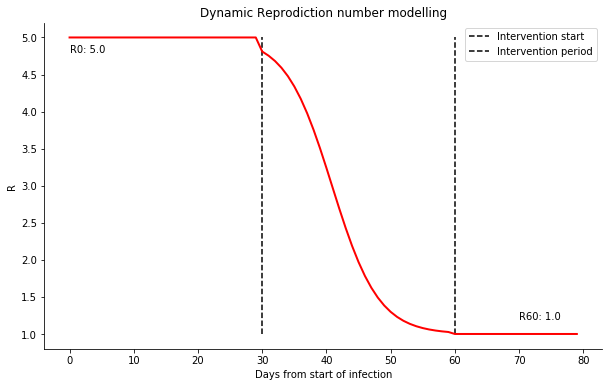

In [38]:
max_R = 5.
min_R = 1.
simulation_days=100
intervention_start=30
intervention_period=30

example_R = calculate_reproduction_number(
    max_R, min_R, 
    simulation_days=simulation_days, 
    intervention_start=intervention_start,
    intervention_period=intervention_period
)

plt.figure(figsize=(10, 6))
plt.plot(example_R[:80], linewidth=2, color='red')
plt.title("Dynamic Reprodiction number modelling")
plt.text(0, max_R-0.2, f"R0: {max_R}")
plt.text(70, min_R+0.2, f"R60: {min_R}")
plt.vlines(intervention_start, min_R, max_R, 
           label='Intervention start', linestyles='dashed')
plt.vlines(
    intervention_start+intervention_period, min_R, max_R, 
    label='Intervention period', linestyles='dashed')
plt.ylabel("R")
plt.xlabel("Days from start of infection")
plt.legend()

sns.despine()
plt.show()

# Comparing to Johns Hopkins Data

In [39]:
main_link = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
CONFIRMED = pd.read_csv(main_link+'time_series_covid19_confirmed_global.csv' )
DEATHS = pd.read_csv(main_link+'time_series_covid19_deaths_global.csv')
RECOVERED = pd.read_csv(main_link+'time_series_covid19_recovered_global.csv')

In [40]:
country = 'China'

confirmed_country = CONFIRMED[CONFIRMED['Country/Region']==country].sum()[4:].values
first_case = np.argwhere(confirmed_country)[0][0]
confirmed_country = confirmed_country[first_case:]

deaths_country = DEATHS[DEATHS['Country/Region']==country].sum()[4:].values[first_case:]
recovered_country = RECOVERED[RECOVERED['Country/Region']==country].sum()[4:].values[first_case:]

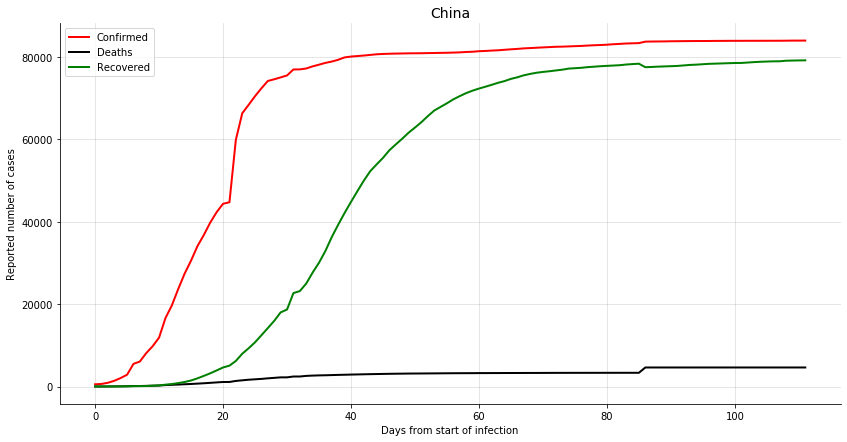

In [42]:
plt.figure(figsize=(14, 7))
plt.title(country, fontsize=14)
plt.plot(
    confirmed_country,
    linewidth=2,
    label='Confirmed',
    color='red'
)
plt.plot(
    deaths_country, 
    linewidth=2,
    label='Deaths',
    color='black'
)
plt.plot(
    recovered_country,
    linewidth=2,
    label='Recovered',
    color='green'
)
plt.legend()
plt.xlabel('Days from start of infection')
plt.ylabel("Reported number of cases")
plt.grid(alpha=0.4)
sns.despine()
plt.show()

# Important assumption 

Only 10% of cases, on average, were reported in the China statistics (estimate from Johns Hopkins University)

In [80]:
max_R0 = 4
min_R0 = 1
SIMULATION_DAYS = 150

beta = calculate_reproduction_number(
    max_R0, min_R0, SIMULATION_DAYS, intervention_start=30, intervention_period=14
)

# Dividing the initial number of cases by 0.1 to adjust for the unobserved cases
sir_model = SIR(8364977, I0=444/0.1, beta=beta/14, gamma=0.0576*2, days=SIMULATION_DAYS)
S, I, R = sir_model.run()

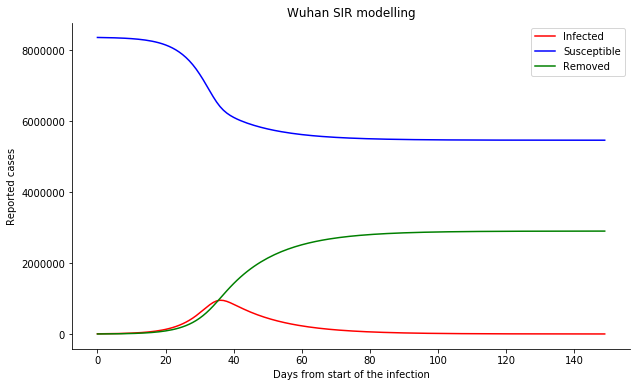

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(I, c='red', label='Infected')
plt.plot(S, c='blue', label='Susceptible')
plt.plot(R, c='green', label='Removed')
plt.legend()
plt.title("Wuhan SIR modelling")
plt.ylabel("Reported cases")
plt.xlabel("Days from start of the infection")
sns.despine()
plt.show()

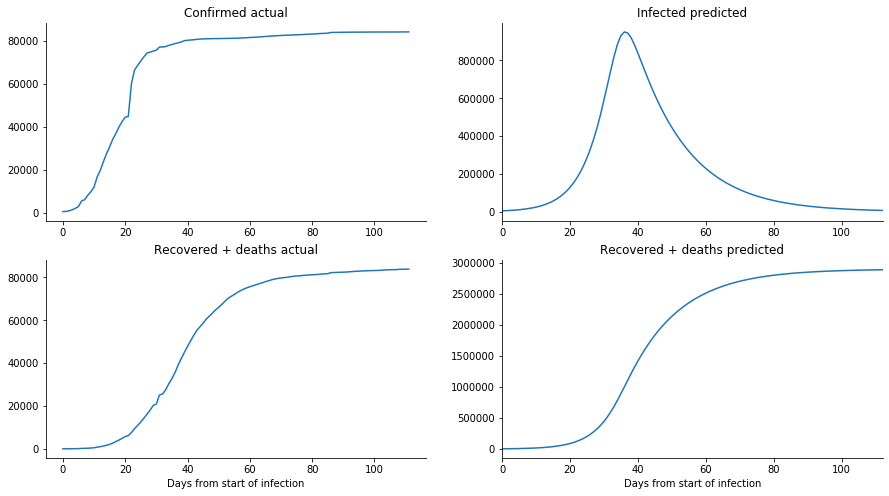

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs[0, 0].plot(confirmed_country)
axs[0, 0].set_title("Confirmed actual")
sns.despine()
axs[0, 1].plot(I)
axs[0, 1].set_title("Infected predicted")
axs[0, 1].set_xlim(0, len(confirmed_country))

axs[1, 0].plot(deaths_country+recovered_country)
axs[1, 0].set_title("Recovered + deaths actual")
axs[1, 0].set_xlabel("Days from start of infection")
axs[1, 1].plot(R)
sns.despine()
axs[1, 1].set_title("Recovered + deaths predicted")
axs[1, 1].set_xlim(0, len(confirmed_country))
axs[1, 1].set_xlabel("Days from start of infection")
plt.show()

# <center> COVID-19 Spread Simulation </center>

<img src="../pictures/spread_schema.png" width=700>

In [54]:
# taking unique source-destination pairs
connections = connections.groupby(["source_airport", 'dest_airport'], as_index=False).agg({
    "destination_flights":np.nansum,
    "lat_source":min,
    "long_source":min,
    "lat_dest":min,
    "long_dest":min
})

## NetworkX graph

In [82]:
connections.head()

,source_airport,dest_airport,destination_flights,lat_source,long_source,lat_dest,long_dest
0,AAE,ALG,0.733333,36.822201,7.809174,36.691002,3.215410
1,AAE,CDG,0.733333,36.822201,7.809174,49.012798,2.550000
2,AAE,IST,0.733333,36.822201,7.809174,41.275278,28.751944
3,AAE,LYS,0.733333,36.822201,7.809174,45.725556,5.081111
4,AAE,MRS,1.466667,36.822201,7.809174,43.439272,5.221424


In [55]:
connections_graph = nx.from_pandas_edgelist(
    connections, 
    source = 'source_airport', 
    target = 'dest_airport',
    create_using = nx.DiGraph()
)

In [59]:
len(connections_graph.nodes)

3190

## Auxillary data models

In [60]:
def city_neighbours(city_name, connections_graph=connections_graph):
    city_airports = CITY_TO_AIRPORT_CODE[city_name]
    neighbours = []
    for city in city_airports:
        neighbours.extend(list(connections_graph.neighbors(city)))
    return neighbours

In [61]:
AIRPORT_CODE_TO_CITY = airport_df[['City', 'IATA']].set_index("IATA").to_dict()['City']
CITY_TO_AIRPORT_CODE = airport_df[['City', 'IATA']].groupby("City")['IATA'].unique().to_dict()
CITY_TO_AIRPORT_CODE = {k:list(v) for k, v in CITY_TO_AIRPORT_CODE.items()}
CITY_POPULATION = airport_df[['City', 'city_population']].set_index("City").to_dict()['city_population']


CITY_NEIGHBOURS = {}
for city in airport_df.City.unique():
    try:
        CITY_NEIGHBOURS[city] = city_neighbours(city)
    except:
        continue
        
NUMBER_OF_FLIGHTS = dict(zip(tuple(
    zip(
        connections.source_airport, 
        connections.dest_airport
    )),
    connections.destination_flights
))

## Simulation functions

In [62]:
def get_city_neighbours(city_name):
    return CITY_NEIGHBOURS[city_name]

def get_healthy_airports(airports):
    airports = list(set(airports) - set(INFECTED_AIRPORTS))
    return airports

def get_infected_airports(airports):
    airports = list(set(airports).intersection(set(INFECTED_AIRPORTS)))
    return airports

def airports_to_cities(airports):
    return list(set([AIRPORT_CODE_TO_CITY[code] for code in airports]))

def get_number_of_flights(source, destination):
    if not isinstance(source, list):
        source = [source]
    if not isinstance(destination, list):
        destination = [destination]
    flights = 0
    for source in source:
        for dest in destination:
            flights+=NUMBER_OF_FLIGHTS[(source, dest)]
    return flights


def get_infected_number(city_name, simulation_day):
    infection_day = INFECTED_CITIES[city_name]['day']
    return INFECTED_CITIES[city_name]['infected'][simulation_day-infection_day]


def calculate_infection_prob(current_susceptible_city, DAY):
    
    current_susceptible_airports = CITY_TO_AIRPORT_CODE[current_susceptible_city]
    current_infected_neighbours = get_infected_airports(get_city_neighbours(current_susceptible_city))

    flights = []
    infected_populations = []
    total_populations = []

    for infected_neighbour in current_infected_neighbours:
        infected_city_name = AIRPORT_CODE_TO_CITY[infected_neighbour]
        flights.append(get_number_of_flights(infected_neighbour, current_susceptible_airports))
        infected_populations.append(get_infected_number(infected_city_name, DAY))
        total_populations.append(CITY_POPULATION[infected_city_name])

    infection_probability = prob_city_infected(infected_populations, total_populations, flights)
    return infection_probability

def run_neighbour_simulation(current_susceptible_city, current_infection_source_city, DAY):
    
    infection_probability = calculate_infection_prob(current_susceptible_city, DAY)

    if np.random.random() < infection_probability:
        S, I, R = run_sir(
            city_population=CITY_POPULATION[current_susceptible_city],
            first_infected_number=100
        )
        return {current_susceptible_city:{
            'day':DAY, 
            'infected':I,
            'susceptible':S,
            'recovered':R,
            'from': current_infection_source_city
        }}
        
        
def run_infectious_city_simulation(current_infection_source_city, DAY):
    neighbour_airports = get_city_neighbours(current_infection_source_city)
    susceptible_airports = get_healthy_airports(neighbour_airports)
    susceptible_cities = airports_to_cities(susceptible_airports)

    results = []
    for current_susceptible_city in tqdm_notebook(
        susceptible_cities, 
        leave=False, 
        desc='susceptible', 
        disable=True
    ):
        
        try:
            results.append(run_neighbour_simulation(current_susceptible_city, current_infection_source_city, DAY))
        except:
            continue
            
    results = [res for res in results if res]
    return results

## Configurations for scenarios

- Realistic: intervention starts after 30 days, it takes 14 days to enforce lockdown
- Optimistic: intervention starts after 14 days, it takes 7 days to enforce lockdown
- Pessimistic: intervention starts after 60 days, it takes 30 days to enforce lockdown

In [68]:
NUMBER_OF_SIMULATIONS = 10
SIMULATION_DAYS = 200
VERBOSE = True

max_R = 4
min_R = 1

GAMMA = 0.0576*2
REPRODUCTION_NUMBER = calculate_reproduction_number(
    max_R, min_R, 
    SIMULATION_DAYS, 
    intervention_start=60, 
    intervention_period=30)

def run_sir(
        city_population, first_infected_number, 
        reproduction_number=REPRODUCTION_NUMBER, 
        gamma=GAMMA, days=SIMULATION_DAYS
    ):
    sir_model = SIR(
        city_population, I0=first_infected_number, beta=reproduction_number/14, gamma=gamma, days=days
    )
    S, I, R = sir_model.run()
    return S, I, R

# Simulation run

In [84]:
INFECTED_CITIES = {}
INFECTED_AIRPORTS = []
NEW_INFECTED = {}

for simulation_run in tqdm_notebook(range(NUMBER_OF_SIMULATIONS), leave=False):
    # Always start at Wuhan on day 0
    S, I, R = run_sir(CITY_POPULATION['Wuhan'], 444/0.1)
    INFECTED_CITIES = {'Wuhan':{'day':0, 'infected':I, 'susceptible':S, 'recovered':R, 'from':'Wuhan'}}
    INFECTED_AIRPORTS = ['WUH']
    
    for DAY in tqdm_notebook(range(0, SIMULATION_DAYS), desc='Day', leave=False):
        CHECKED_SUSCEPTIBLE_CITIES = []

        for current_infection_source_city in tqdm_notebook(
            INFECTED_CITIES.keys(),
            leave=False, 
            desc='infection sources',
            disable=not VERBOSE
            ):

            results = run_infectious_city_simulation(current_infection_source_city, DAY)
            NEW_INFECTED.update(dict(ChainMap(*results)))

        INFECTED_CITIES.update(NEW_INFECTED)
        NEW_INFECTED = {}
        INFECTED_AIRPORTS = sum([CITY_TO_AIRPORT_CODE[city] for city in INFECTED_CITIES.keys()], [])

    with open(f"../simulation_data/INFECTED_CITIES_mild_{simulation_run}", 'wb') as f:
        pickle.dump(INFECTED_CITIES, f)